<a href="https://colab.research.google.com/github/slopatek/Crude_Oil_Prices_Time_Series_Analysis/blob/main/Crude_Oil_Prices_TSA_Part_03_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crude Oil Prices - Time Series Analysis (Part 3)**

The ultimate objective is to model crude oil prices using machine learning techniues: 
* In part 1 my focus was on SARIMA & ETS models
* In part 2 I have tried some deep learning solutions in a univariate setup while...
* Here in part 3 I will step things up a notch and try multivariate regression 

# **Preparing the ground**

Let's import usual suspects, upgrade our gear, code some useful functions & features and eventually download the data, that we will work with....

## **Required imports**

No surprises, pretty standard imports...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import os
import datetime as dt
from timeit import default_timer as timer 
from pandas.tseries.offsets import BDay
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None, "display.min_rows", 20, "display.max_rows", 50)


## **GPU check**

Let's see if we have access to some hardware accelerator.


In [ ]:
!nvidia-smi #-L

Wed Mar  8 15:40:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |   2357MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Yes !! We do !!

## **Useful functions**

The following cells might turn out to be useful at a later stage. Let's start from colors to keep our visuals consistent throught the notebook.

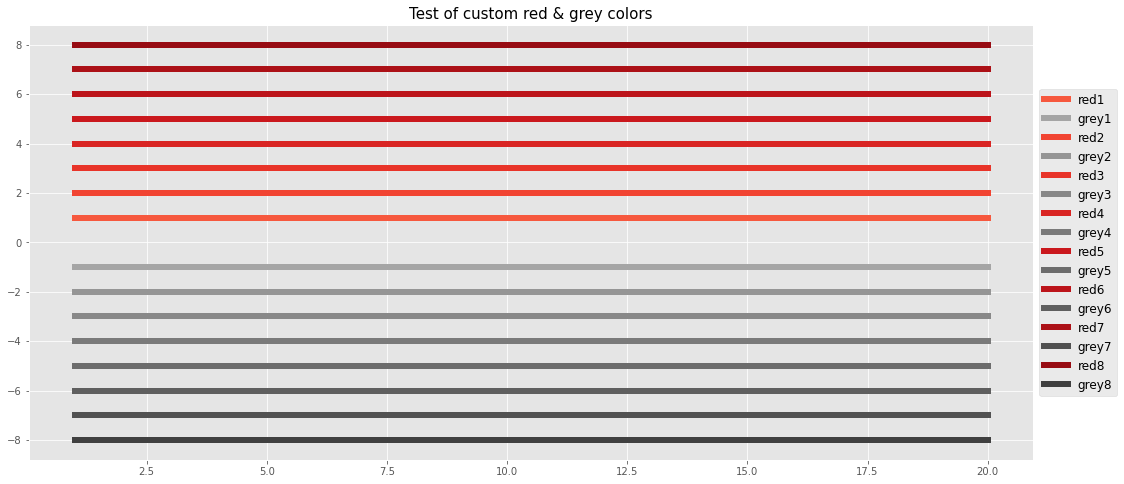

In [12]:
for i in range(3, 11, 1):
  globals()[f"red{i-2}"] = plt.cm.Reds(0.4 + i/20)
  globals()[f"grey{i-2}"] = plt.cm.Greys(0.3 + i/20)
  
x = np.arange(1,21)
y = np.zeros(20)
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Test of custom red & grey colors', fontsize = 15)
for i in range(1,9,1):
  plt.plot(x, y+i, lw=6, color = globals()[f"red{i}"], label = f'red{i}')
  plt.plot(x, y-i, lw=6, color = globals()[f"grey{i}"], label = f'grey{i}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

In [ ]:
def scatter_ts(timesteps, values, start=0, end=None, label=None, chart_title=None, size = 10, color = "red"):
  plt.scatter(timesteps[start:end], values[start:end], c = color, s = size, label=label)
  plt.xlabel("Date")
  plt.ylabel("Brent Price (USD/bbl)")
  if label:
    plt.legend(fontsize=12)
  plt.title(chart_title)
  plt.grid(True)

def calculate_mase(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  naive_mae = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / naive_mae

def assess_preds(y_true, y_pred):
  y_true = tf.squeeze(tf.cast(y_true, dtype=tf.float32))
  y_pred = tf.squeeze(tf.cast(y_pred, dtype=tf.float32))
  mse = (tf.keras.metrics.mean_squared_error(y_true, y_pred)).numpy()
  rmse = (tf.sqrt(mse)).numpy()
  mae = (tf.keras.metrics.mean_absolute_error(y_true, y_pred)).numpy()  
  mape = (tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)).numpy()
  mase = (calculate_mase(y_true, y_pred)).numpy() 
  error_dict = {"error_type":["mse", "rmse","mae", "mape", "mase"],
                "error_value":[mse, rmse, mae, mape, mase]}
  error_df = pd.DataFrame(error_dict["error_value"], index = error_dict["error_type"], columns=["error"])
  return np.round(error_df,3)

def vectorized_split_sequence(sequence, steps_in, steps_out):
  if type(sequence) != np.ndarray:
    sequence = np.array(sequence)
  window_step = np.expand_dims(np.arange(steps_in), axis = 0)
  horizon_step = np.expand_dims(np.arange(steps_in, steps_in + steps_out), axis = 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(sequence)-(steps_in + steps_out - 1)), axis = 1)
  horizon_indexes = horizon_step + np.expand_dims(np.arange(len(sequence)-(steps_in + steps_out - 1)), axis = 1)
  return sequence[window_indexes], sequence[horizon_indexes]

def create_checkpoint(name, path = "models_tried"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path, name),
                                            verbose=0,
                                            save_best_only=True)
  
def assess_predictions(actual_data, predicted_data):
  actual_data = tf.squeeze(tf.cast(actual_data, dtype = tf.float32))
  predicted_data = tf.squeeze(tf.cast(predicted_data, dtype=tf.float32))
  pred_error = np.round(tf.sqrt(tf.keras.metrics.mean_squared_error(actual_data, predicted_data)),3)
  return pred_error

def train_test_splitting(data, test_percent = 0.2):
  test_size = int(len(data) * test_percent)
  return data[:-test_size], data[-test_size:]

## **Data retrieval**

In continuation to Part 1 & Part 2 we will choose to work with ICE Brent as predicted variable. In contrast to previous parts though I will test usefullness of a range of exogeanous variables:
* product cracks / refinery margins
* forward curve
* foreign exchange rates
* major equity indices
* US Treasury yields
* physical oil differentials
* oil fundamentals (balances & inventory movements)
* positioning of speculative capital
* monetary indicators (key interest rates & total assets of key central banks)

Let's start from downloading relevant data (daily quatations first)...

In [3]:
!wget https://raw.githubusercontent.com/slopatek/Crude_Oil_Prices_Time_Series_Analysis/main/ICE_Brent_Data_Feed.xlsx
daily_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Daily',
                         index_col = 'Date',
                         parse_dates = True)
print("\n","#"*100, "\n")
daily_df.info()

--2023-03-09 09:26:16--  https://raw.githubusercontent.com/slopatek/Crude_Oil_Prices_Time_Series_Analysis/main/ICE_Brent_Data_Feed.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1916247 (1.8M) [application/octet-stream]
Saving to: ‘ICE_Brent_Data_Feed.xlsx.1’

ICE_Brent_Data_Feed 100%[===================>]   1.83M  --.-KB/s    in 0.04s   

2023-03-09 09:26:17 (45.2 MB/s) - ‘ICE_Brent_Data_Feed.xlsx.1’ saved [1916247/1916247]


 #################################################################################################### 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3945 entries, 2008-01-01 to 2023-02-13
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      ------------

We have close to 4k of data points for each series. Let's see how many null values we need to deal with

In [ ]:
daily_df.isna().sum()

Brent M1                       41
Brent M2                       41
Brent M3                       41
Brent M4                       41
Brent M5                       41
Brent M6                       41
Brent M7                       41
Brent M8                       41
Brent M9                       41
Brent M10                      42
Brent M11                      42
Brent M12                      41
Brent M13                      41
Gas Oil M1                     41
WTI M1                        135
RBOB M1                       135
Heat Oil M1                   135
US Dollar Index                43
Euro                            1
Japenese Yen                    2
British Pound                   2
Canadian Dollar                 2
Swedish Korona                  2
Swiss Frank                     1
Korean Won                      1
Mexican Peso                    2
South African Rand              2
Brasilian Real                  2
Chinese Renminbi                2
Indian Rupee  

Time to have a look at key stats for each & every one of them...

In [ ]:
daily_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Brent M1,3904.0,78.357751,26.066125,19.3300,56.357500,74.52000,105.180000,146.0800
Brent M2,3904.0,78.303619,25.599260,22.7400,56.752500,74.49000,104.625000,146.6000
Brent M3,3904.0,78.281596,25.205553,25.1600,57.007500,74.53000,104.065000,147.0500
Brent M4,3904.0,78.262907,24.858021,27.0500,57.257500,74.61500,103.695000,147.4300
Brent M5,3904.0,78.237395,24.544027,28.5700,57.387500,74.88000,103.287500,147.7300
Brent M6,3904.0,78.202070,24.260055,29.8600,57.557500,75.03500,102.842500,148.1300
Brent M7,3904.0,78.151165,24.001993,30.8800,57.620000,75.16500,102.387500,148.4100
Brent M8,3904.0,78.087561,23.761813,31.7300,57.737500,75.15500,102.022500,148.5400
Brent M9,3904.0,78.020233,23.537202,32.4800,57.737500,75.05500,101.662500,148.5400
Brent M10,3903.0,77.948340,23.330064,33.1600,57.895000,75.00000,101.340000,148.4700


Now is a good moment to deal with missing data... Front Fill is our strategy so that old data is used until new data is available.

In [ ]:
daily_df.ffill(inplace=True)
daily_df.backfill(inplace=True)
daily_df.isna().sum()

Brent M1                      0
Brent M2                      0
Brent M3                      0
Brent M4                      0
Brent M5                      0
Brent M6                      0
Brent M7                      0
Brent M8                      0
Brent M9                      0
Brent M10                     0
Brent M11                     0
Brent M12                     0
Brent M13                     0
Gas Oil M1                    0
WTI M1                        0
RBOB M1                       0
Heat Oil M1                   0
US Dollar Index               0
Euro                          0
Japenese Yen                  0
British Pound                 0
Canadian Dollar               0
Swedish Korona                0
Swiss Frank                   0
Korean Won                    0
Mexican Peso                  0
South African Rand            0
Brasilian Real                0
Chinese Renminbi              0
Indian Rupee                  0
Turkish Lira                  0
MSCI wor

Before we proceed further, let us remind ourselves of Brent prices over recent 15 years...

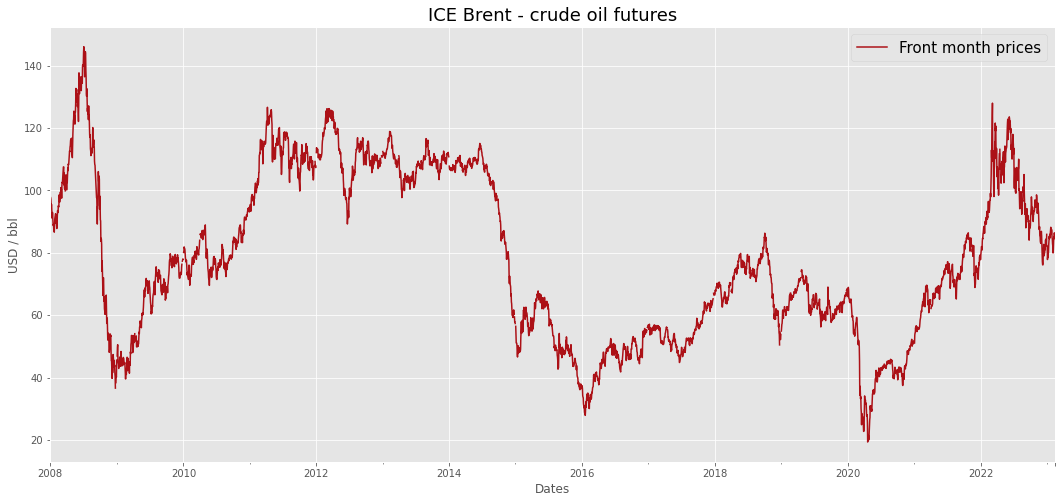

In [29]:
daily_df['Brent M1'].plot(figsize=(18,8), label = "Front month prices", color = red7)
plt.title("ICE Brent - crude oil futures", fontsize=18)
plt.ylabel("USD / bbl")
plt.xlabel("Dates")
plt.legend(fontsize=15);

# **Feature engineering**

In order to raise predictive power of our models we will try to use our domain knowledge to extract useful features from our data. For that end we will use a lot of visuals to familiarize with data and have better understanding of it. We will start with... 

### **Forward curve** 

All of those who are into oil markets know that the forward curve is never flat. It is:
* either progressively rising => referred to as *contango* or...
* falling => referred to as *backwardation*
* some combination of the two... pretty wobbly on occasions

As big funs of randomness we have generated 12 random dates with coresponding chart of forward curve over one year horizon. Contango cases are grey while backwardarion cases are red. In all cases intensity of the color is a function of the steepness of the slope of a curve on a given date.

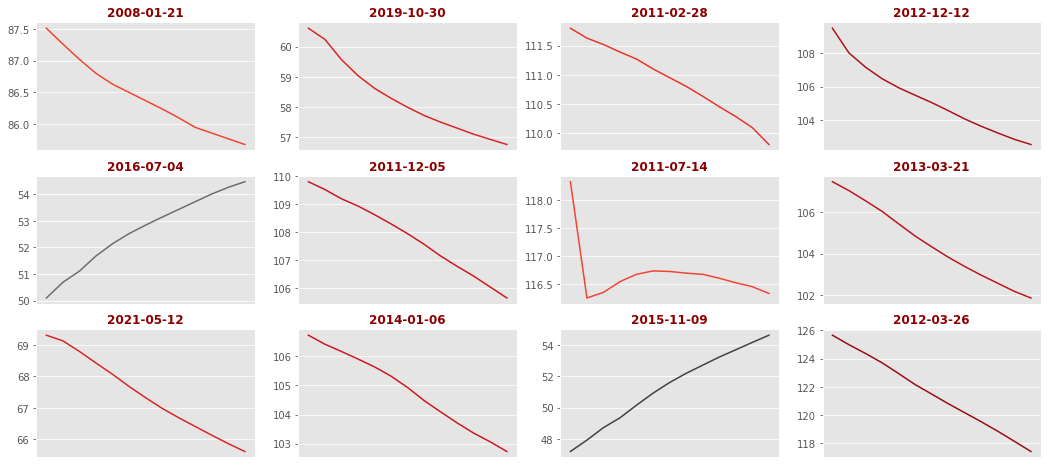

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=4, figsize=(18,8))
for r in range(3):
  for c in range(4):
    rand_date = np.random.choice(daily_df.index)
    axes[r,c].set_title(pd.to_datetime(rand_date).strftime('%Y-%m-%d'), fontsize = 12, color='darkred', fontweight="bold")
    structure = daily_df.loc[rand_date, 'Brent M13']-daily_df.loc[rand_date, 'Brent M1']
    if structure>0:
      structure_index = min(int(structure )+1,8)
      line_color = globals()[f"grey{structure_index}"]
    else:
      structure_index = min(int(-structure)+1,8)
      line_color = globals()[f"red{structure_index}"]
    axes[r,c].plot(daily_df.loc[rand_date,'Brent M1':'Brent M13'], color = line_color)
    axes[r,c].set_xticks([]);

Instead of feeding all of the data points into our models it would be wise to:
* capture market structure over short horizon (like a month)
* capture market structure over longer horizon (like a year)
* get rid of the rest of the forward curve data

In [ ]:
daily_df['1M_Structure'] = daily_df['Brent M1'] - daily_df['Brent M2']
daily_df['1Y_Structure'] = daily_df['Brent M1'] - daily_df['Brent M13']
daily_df['Gasoi_Crack'] = (daily_df['Gas Oil M1'] / 7.45) - daily_df['Brent M1']
daily_df['3-2-1 Margin'] = (2 * 42 * daily_df['RBOB M1'] + 42 * daily_df['Heat Oil M1']) - (3* daily_df['WTI M1'])
daily_df.drop(daily_df.loc[:,'Brent M2':'Heat Oil M1'], axis=1, inplace=True)
daily_df.head(3)

,Brent M1,US Dollar Index,Euro,Japenese Yen,British Pound,Canadian Dollar,Swedish Korona,Swiss Frank,Korean Won,Mexican Peso,South African Rand,Brasilian Real,Chinese Renminbi,Indian Rupee,Turkish Lira,MSCI world equity,MS Emerging Markets,EZ Stocks,Pan European STOXX 600,Nasdaq Composite,S&P 500 futures,DJIA futures,MSCI ex-Japan Asia Pacific,US Treasury 2Y Yield,US Treasury 5Y Yield,US Treasury 10Y Yield,Forcados,Azeri,Oseberg,Saharan,CPC,Kirkuk,Urals,1M_Structure,1Y_Structure,Gasoi_Crack,3-2-1 Margin
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-01,97.84,76.01,1.4725,109.58,1.9812,0.9934,6.3927,1.1182,936.7,10.916,6.8070,1.7619,7.2934,39.3,1.1675,403.26,1245.95,409.93,360.08,2609.63,1458.50,13136.0,529.76,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080
2008-01-02,97.84,76.01,1.4725,109.58,1.9812,0.9934,6.3927,1.1182,936.7,10.916,6.8070,1.7619,7.2934,39.3,1.1675,400.47,1235.23,409.93,360.08,2609.63,1458.50,13136.0,526.06,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080
2008-01-03,97.60,75.92,1.4746,109.23,1.9706,0.9890,6.3411,1.1111,936.2,10.886,6.8252,1.7509,7.2725,39.2,1.1650,399.81,1227.51,408.20,358.95,2602.68,1458.75,13143.0,519.77,2.8148,3.2523,3.8937,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.22,4.02,17.903356,24.9234


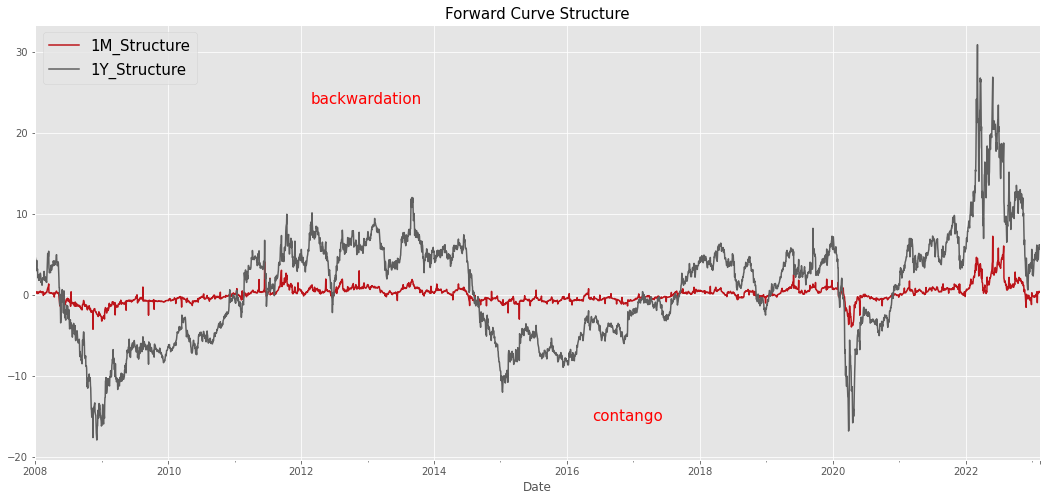

In [ ]:
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Forward Curve Structure', fontsize = 15)
daily_df[['1M_Structure','1Y_Structure']].plot(ax=ax, color=[red6, grey6])
ax.text(0.33*(left+right), 0.83*(bottom+top), 'backwardation',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15, color='red',
        transform=ax.transAxes)
ax.text(0.59*(left+right), 0.1*(bottom+top), 'contango',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15, color='red',
        transform=ax.transAxes)
ax.legend(fontsize = 15, loc='best');

### **Foreign exchange**

It is obvious that oil prices are highly reactive to relative streangth of american dollar. Not only it is used to quote oil and process payments, it is also considered a safe harbor, thus benefiting when risk sentiment sours. Oil, on the other hand, benefits when risk sentiment is firmly on. 

I have downloaded a range of currencies traded against USD. First thing that we need to do is to correct EUR & GBP so we could compare apples to apples.

In [ ]:
daily_df['Euro'] = daily_df['Euro'].apply(lambda x : 1 / x)
daily_df['British Pound'] = daily_df['British Pound'].apply(lambda x : 1 / x)
daily_df.head(3)

,Brent M1,US Dollar Index,Euro,Japenese Yen,British Pound,Canadian Dollar,Swedish Korona,Swiss Frank,Korean Won,Mexican Peso,South African Rand,Brasilian Real,Chinese Renminbi,Indian Rupee,Turkish Lira,MSCI world equity,MS Emerging Markets,EZ Stocks,Pan European STOXX 600,Nasdaq Composite,S&P 500 futures,DJIA futures,MSCI ex-Japan Asia Pacific,US Treasury 2Y Yield,US Treasury 5Y Yield,US Treasury 10Y Yield,Forcados,Azeri,Oseberg,Saharan,CPC,Kirkuk,Urals,1M_Structure,1Y_Structure,Gasoi_Crack,3-2-1 Margin
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-01,97.84,76.01,0.679117,109.58,0.504745,0.9934,6.3927,1.1182,936.7,10.916,6.8070,1.7619,7.2934,39.3,1.1675,403.26,1245.95,409.93,360.08,2609.63,1458.50,13136.0,529.76,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080
2008-01-02,97.84,76.01,0.679117,109.58,0.504745,0.9934,6.3927,1.1182,936.7,10.916,6.8070,1.7619,7.2934,39.3,1.1675,400.47,1235.23,409.93,360.08,2609.63,1458.50,13136.0,526.06,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080
2008-01-03,97.60,75.92,0.678150,109.23,0.507460,0.9890,6.3411,1.1111,936.2,10.886,6.8252,1.7509,7.2725,39.2,1.1650,399.81,1227.51,408.20,358.95,2602.68,1458.75,13143.0,519.77,2.8148,3.2523,3.8937,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.22,4.02,17.903356,24.9234


Now we are ready to visualize the rates, starting from developed economies...

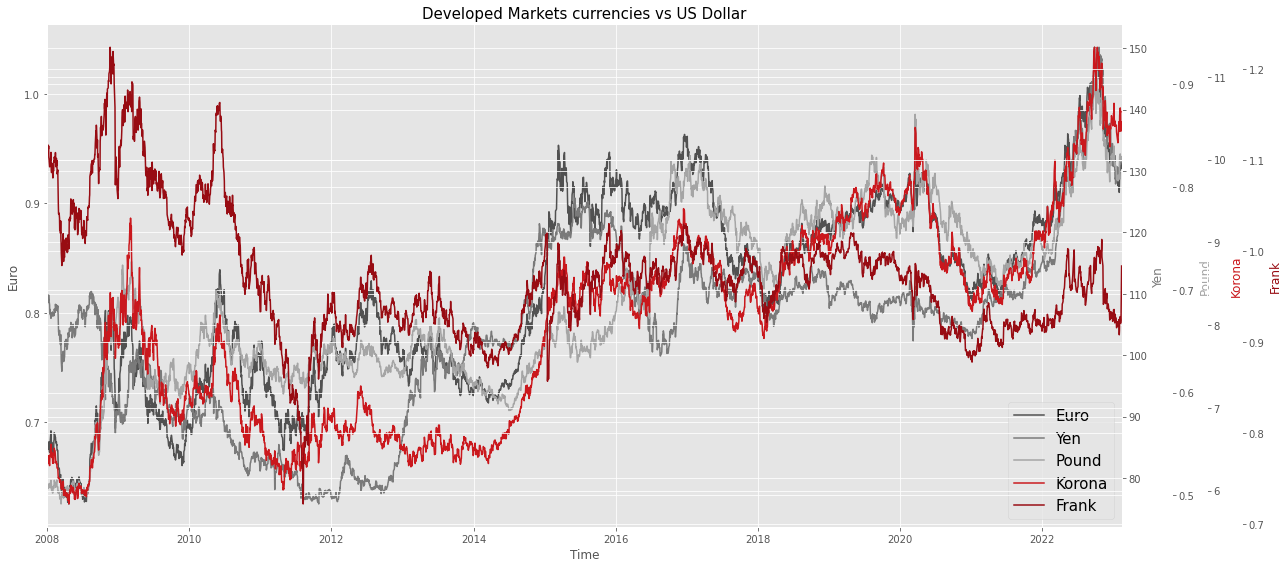

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Developed Markets currencies vs US Dollar', fontsize = 15)

ax1 = ax.twinx()
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()    
ax.set_xlim(daily_df.index[0], daily_df.index[-1])
    
ax.set_xlabel("Time")
ax.set_ylabel("Euro")
ax1.set_ylabel("Yen")
ax2.set_ylabel("Pound")
ax3.set_ylabel("Korona")
ax4.set_ylabel("Frank")

p1, = ax.plot(daily_df.index, daily_df['Euro'],    color=grey7, label="Euro")
p2, = ax1.plot(daily_df.index, daily_df['Japenese Yen'],    color=grey4, label="Yen")
p3, = ax2.plot(daily_df.index, daily_df['British Pound'], color=grey1, label="Pound")
p4, = ax3.plot(daily_df.index, daily_df['Swedish Korona'], color=red5, label="Korona")
p5, = ax4.plot(daily_df.index, daily_df['Swiss Frank'], color=red8, label="Frank")

lns = [p1, p2, p3, p4, p5]
ax.legend(handles=lns, fontsize = 15, loc='lower right')
ax2.spines['right'].set_position(('outward',50))
ax3.spines['right'].set_position(('outward',85))
ax4.spines['right'].set_position(('outward',120))

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())
ax3.yaxis.label.set_color(p4.get_color())
ax3.set_frame_on(True)
ax4.yaxis.label.set_color(p5.get_color())

fig.tight_layout();

At which point we could have a look at currencies of emerging economies...

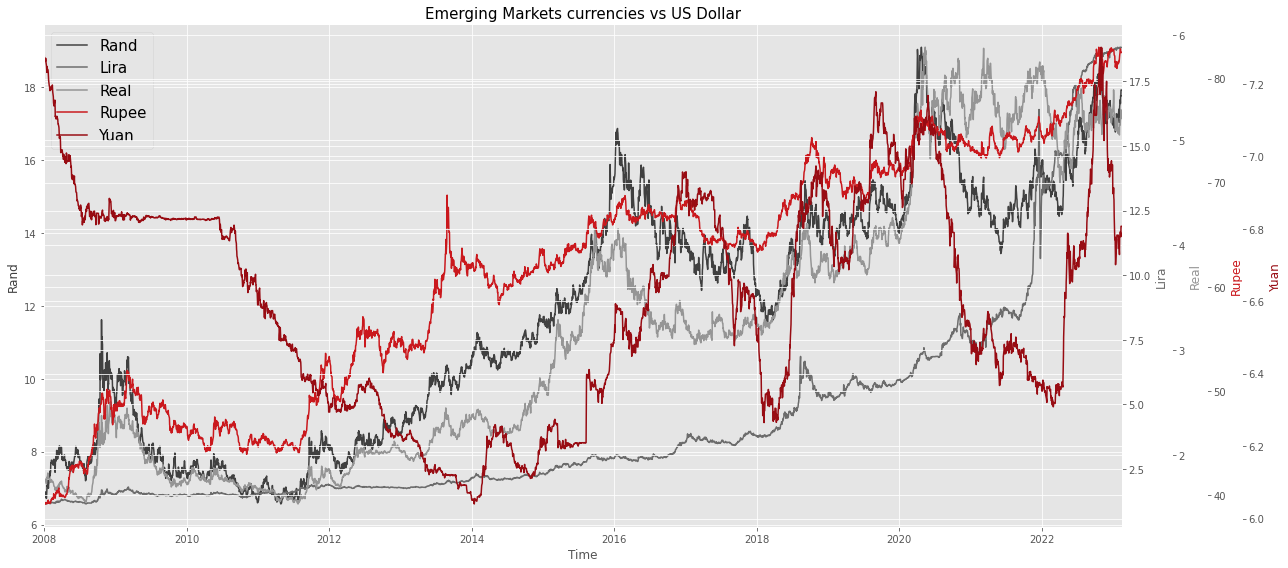

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Emerging Markets currencies vs US Dollar', fontsize = 15)

ax1 = ax.twinx()
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()    
ax.set_xlim(daily_df.index[0], daily_df.index[-1])
    
ax.set_xlabel("Time")
ax.set_ylabel("Rand")
ax1.set_ylabel("Lira")
ax2.set_ylabel("Real")
ax3.set_ylabel("Rupee")
ax4.set_ylabel("Yuan")

p1, = ax.plot(daily_df.index, daily_df['South African Rand'],    color=grey8, label="Rand")
p2, = ax1.plot(daily_df.index, daily_df['Turkish Lira'],    color=grey5, label="Lira")
p3, = ax2.plot(daily_df.index, daily_df['Brasilian Real'], color=grey2, label="Real")
p4, = ax3.plot(daily_df.index, daily_df['Indian Rupee'], color=red5, label="Rupee")
p5, = ax4.plot(daily_df.index, daily_df['Chinese Renminbi'], color=red8, label="Yuan")

lns = [p1, p2, p3, p4, p5]
ax.legend(handles=lns, fontsize = 15, loc='best')
ax2.spines['right'].set_position(('outward',50))
ax3.spines['right'].set_position(('outward',85))
ax4.spines['right'].set_position(('outward',120))

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())
ax3.yaxis.label.set_color(p4.get_color())
ax3.set_frame_on(True)
ax4.yaxis.label.set_color(p5.get_color())

fig.tight_layout();

Using all the FX rates does not seam reasonable and would be expensive computationally so let's reduce that to:
* one rate for Developed Markets currencies (a natural choice here is USD Index versus a basket of currencies)
* one rate for Emerging Markets currencies (we could mimmick the logic of USD Index)

Not all currencies carry equal weights in the indexes. While EUR has by far the biggest weight in USD Index, I chose to put heavier weights on Chinese Yuan & Indian Rupee in the EM Index, taking into account the role they play as far as incremental oil demand is concerned.

In [ ]:
daily_df['EM Index'] = daily_df.apply(lambda row : (row['Indian Rupee']**0.35) *  (row['Chinese Renminbi']**0.35) *  (row['Brasilian Real']**0.10) \
                                      * (row['South African Rand']**0.10) * (row['Turkish Lira']**0.10), axis=1)
daily_df.head(3)

,Brent M1,US Dollar Index,Euro,Japenese Yen,British Pound,Canadian Dollar,Swedish Korona,Swiss Frank,Korean Won,Mexican Peso,South African Rand,Brasilian Real,Chinese Renminbi,Indian Rupee,Turkish Lira,MSCI world equity,MS Emerging Markets,EZ Stocks,Pan European STOXX 600,Nasdaq Composite,S&P 500 futures,DJIA futures,MSCI ex-Japan Asia Pacific,US Treasury 2Y Yield,US Treasury 5Y Yield,US Treasury 10Y Yield,Forcados,Azeri,Oseberg,Saharan,CPC,Kirkuk,Urals,1M_Structure,1Y_Structure,Gasoi_Crack,3-2-1 Margin,EM Index
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-01,97.84,76.01,0.679117,109.58,0.504745,0.9934,6.3927,1.1182,936.7,10.916,6.8070,1.7619,7.2934,39.3,1.1675,403.26,1245.95,409.93,360.08,2609.63,1458.50,13136.0,529.76,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080,9.433705
2008-01-02,97.84,76.01,0.679117,109.58,0.504745,0.9934,6.3927,1.1182,936.7,10.916,6.8070,1.7619,7.2934,39.3,1.1675,400.47,1235.23,409.93,360.08,2609.63,1458.50,13136.0,526.06,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080,9.433705
2008-01-03,97.60,75.92,0.678150,109.23,0.507460,0.9890,6.3411,1.1111,936.2,10.886,6.8252,1.7509,7.2725,39.2,1.1650,399.81,1227.51,408.20,358.95,2602.68,1458.75,13143.0,519.77,2.8148,3.2523,3.8937,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.22,4.02,17.903356,24.9234,9.410435


In [ ]:
print(daily_df['US Dollar Index'].mean(), daily_df['EM Index'].mean(), daily_df['US Dollar Index'].mean() / daily_df['EM Index'].mean())

88.99224359949304 13.218713823323238 6.732292172213773


In [ ]:
daily_df['EM Index'] = daily_df['EM Index'].apply(lambda x : x * 6.732)

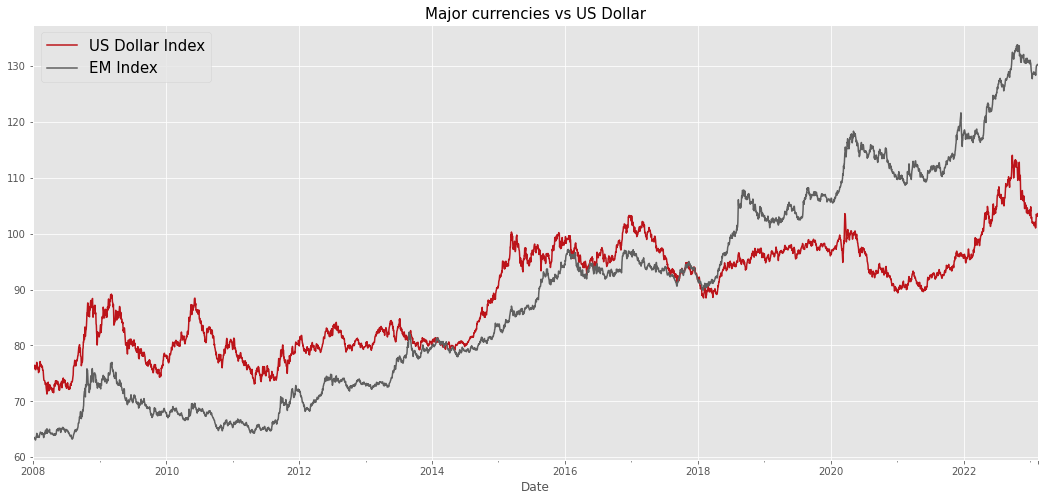

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Major currencies vs US Dollar', fontsize = 15)
daily_df[['US Dollar Index','EM Index']].plot(ax=ax, color=[red6, grey6])
ax.legend(fontsize = 15, loc='best');

Looking nice. We may eliminate other FX rates from our data frame.

In [ ]:
daily_df.drop(daily_df.loc[:,'Euro':'Turkish Lira'], axis=1, inplace=True)

In [ ]:
daily_df.head(3)

,Brent M1,US Dollar Index,MSCI world equity,MS Emerging Markets,EZ Stocks,Pan European STOXX 600,Nasdaq Composite,S&P 500 futures,DJIA futures,MSCI ex-Japan Asia Pacific,US Treasury 2Y Yield,US Treasury 5Y Yield,US Treasury 10Y Yield,Forcados,Azeri,Oseberg,Saharan,CPC,Kirkuk,Urals,1M_Structure,1Y_Structure,Gasoi_Crack,3-2-1 Margin,EM Index
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-01,97.84,76.01,403.26,1245.95,409.93,360.08,2609.63,1458.50,13136.0,529.76,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080,63.507702
2008-01-02,97.84,76.01,400.47,1235.23,409.93,360.08,2609.63,1458.50,13136.0,526.06,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080,63.507702
2008-01-03,97.60,75.92,399.81,1227.51,408.20,358.95,2602.68,1458.75,13143.0,519.77,2.8148,3.2523,3.8937,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.22,4.02,17.903356,24.9234,63.351048


### **Equities**

Let us shift our attention to key equity indexes in Europe, Asia and - last but not least - USA. Equities are highly regarded members of risk assets - feature shared with commodities. Hence they tend to react to *risk on - risk off* sentiment in a similar fashion. Taking into consideration the amount of capital behind them, I would not be surprised if they turned out to have some predictive power in our model. Let us visualize their behaviour.

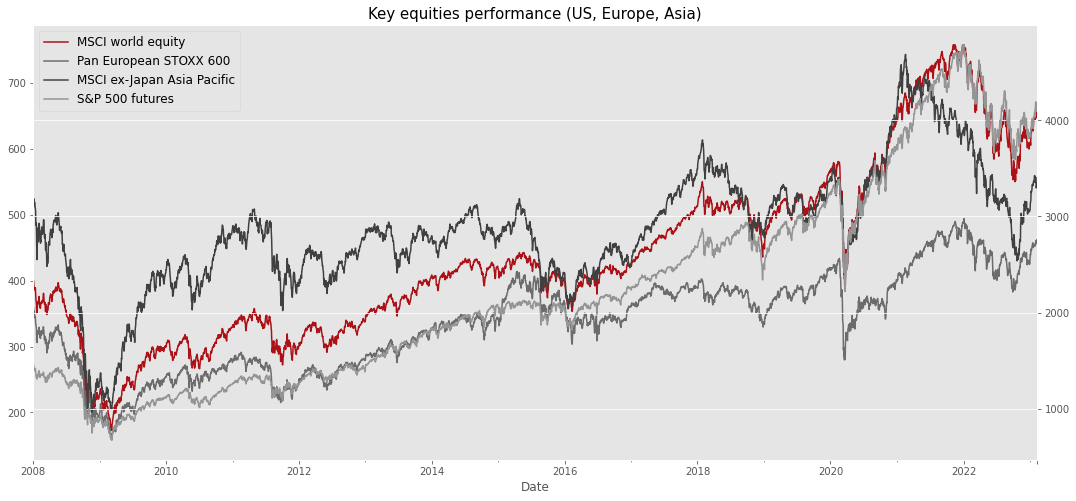

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Key equities performance (US, Europe, Asia)', fontsize = 15)
daily_df[['MSCI world equity','Pan European STOXX 600', 'MSCI ex-Japan Asia Pacific']].plot(ax=ax,color=[red7, grey5, grey8])
daily_df['S&P 500 futures'].plot(ax=ax, color = grey2, secondary_y=True)
ax.legend([ax.get_lines()[0],ax.get_lines()[1],ax.get_lines()[2],ax.right_ax.get_lines()[0]],\
          ['MSCI world equity','Pan European STOXX 600', 'MSCI ex-Japan Asia Pacific','S&P 500 futures'], fontsize=12);

Looking great. I would arbitrarly choose to keep MSCI all-country index as the one representing global equities. Other indices may be removed for now.

In [ ]:
daily_df.drop(daily_df.loc[:,'MS Emerging Markets':'MSCI ex-Japan Asia Pacific'], axis=1, inplace=True)

In [ ]:
daily_df.head(3)

,Brent M1,US Dollar Index,MSCI world equity,US Treasury 2Y Yield,US Treasury 5Y Yield,US Treasury 10Y Yield,Forcados,Azeri,Oseberg,Saharan,CPC,Kirkuk,Urals,1M_Structure,1Y_Structure,Gasoi_Crack,3-2-1 Margin,EM Index
Date,,,,,,,,,,,,,,,,,,
2008-01-01,97.84,76.01,403.26,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080,63.507702
2008-01-02,97.84,76.01,400.47,2.8841,3.2813,3.9071,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.25,4.58,16.925101,24.7080,63.507702
2008-01-03,97.60,75.92,399.81,2.8148,3.2523,3.8937,2.35,2.55,1.55,1.75,0.8,-3.75,-2.95,0.22,4.02,17.903356,24.9234,63.351048


### **US Treasury**

Time to set our focus on US Treasury yields. Let's visualize their behaviour over most recent 15 years.

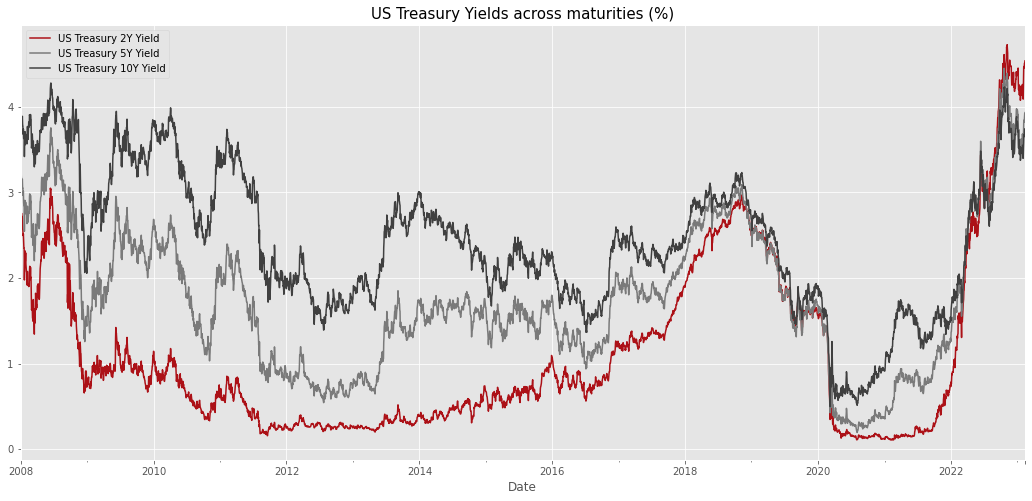

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('US Treasury Yields across maturities (%)', fontsize = 15)
daily_df[['US Treasury 2Y Yield','US Treasury 5Y Yield', 'US Treasury 10Y Yield']].plot(ax=ax,color=[red7, grey4, grey8]);

What is of particular interest to us here is the spread of 10 year yield versus 2 year yield which in the past turned out to be a good predictor of recession in the US economy. Let's see how it looks.

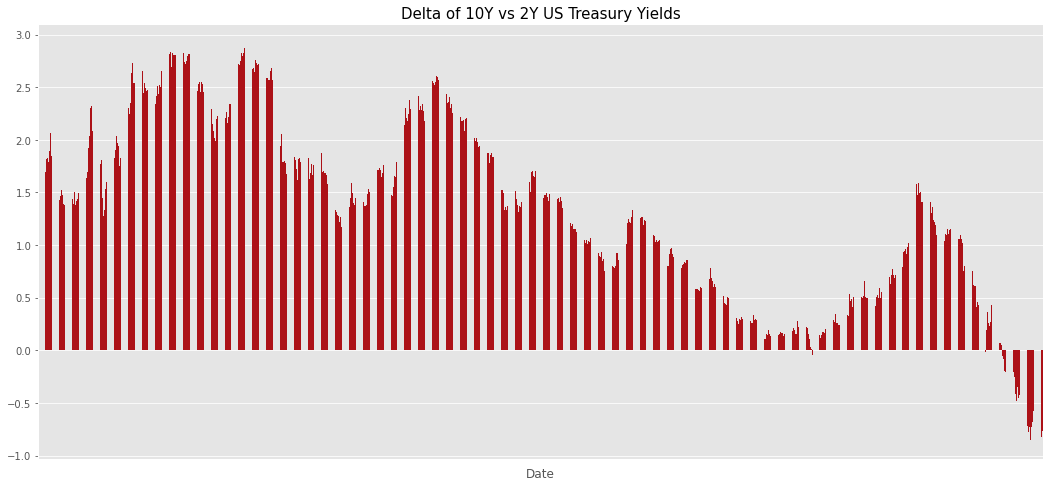

In [ ]:
daily_df['10Y vs 2Y Delta'] = daily_df['US Treasury 10Y Yield'] - daily_df['US Treasury 2Y Yield']
daily_df.drop(daily_df.loc[:,'US Treasury 2Y Yield':'US Treasury 10Y Yield'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Delta of 10Y vs 2Y US Treasury Yields', fontsize = 15)
daily_df['10Y vs 2Y Delta'].plot.bar(ax=ax,color=red7)
ax.set_xticks([]);

### **Physical Diffs**

Crude oil differentials are credited to carry a lot of useful information. Not only they are capable to capture state of market fundamentals in the *tight - loose* spectrum but they also provide insight into *sweet - sour* and *light - heavy* dynamics. Let see how they present themselves...

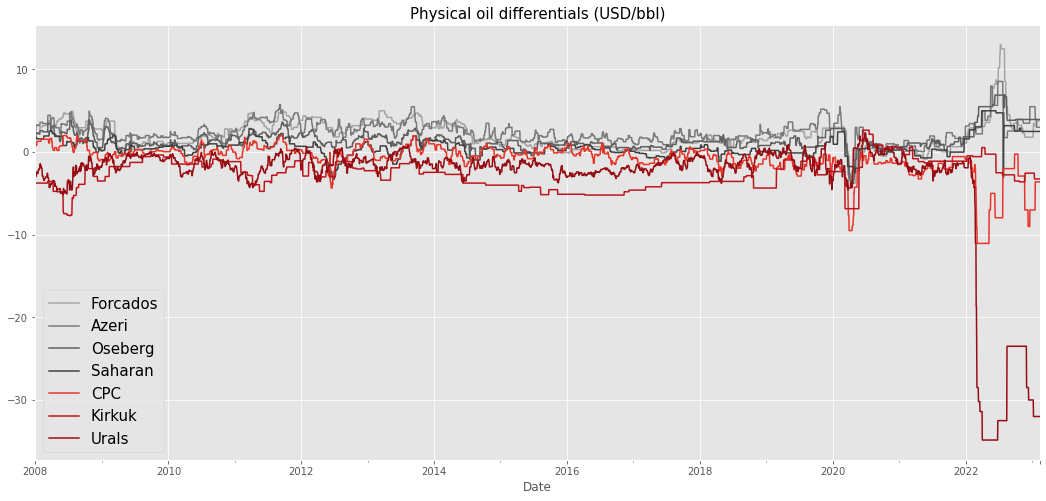

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Physical oil differentials (USD/bbl)', fontsize = 15)
daily_df[['Forcados','Azeri', 'Oseberg', 'Saharan', 'CPC', 'Kirkuk', 'Urals']].plot(ax=ax, color = \
                                                                                    [grey1, grey4, grey6, grey8, red3, red6, red8])
ax.legend(fontsize = 15);

Urals would be our grade of choice to represent sour side of the physical oil market but amid war in Ukraine it has clearly delinked from the rest of the market. Under the circumstances I will choose to go with Kirkuk instead. 

In order to reduce the dimensionality of the dataset I will choose to continue with two physical oil indicators:


1.   Mean differential of a subset of the grades
2.   Sweet - Sour spread



In [ ]:
daily_df['Mean Diff'] = daily_df.apply(lambda x : (x.Forcados + x.Azeri + x.Oseberg + x.Saharan + x.CPC + x.Kirkuk)/6, axis=1)
daily_df['Sweet-Sour Spread'] = daily_df.apply(lambda x : (x.Forcados + x.Azeri)/2 - x.Kirkuk, axis=1)
daily_df.drop(daily_df.loc[:,'Forcados':'Urals'], axis=1, inplace=True)
daily_df.head(3)

,Brent M1,US Dollar Index,MSCI world equity,1M_Structure,1Y_Structure,Gasoi_Crack,3-2-1 Margin,EM Index,10Y vs 2Y Delta,Mean Diff,Sweet-Sour Spread
Date,,,,,,,,,,,
2008-01-01,97.84,76.01,403.26,0.25,4.58,16.925101,24.7080,63.507702,1.0230,0.875,6.2
2008-01-02,97.84,76.01,400.47,0.25,4.58,16.925101,24.7080,63.507702,1.0230,0.875,6.2
2008-01-03,97.60,75.92,399.81,0.22,4.02,17.903356,24.9234,63.351048,1.0789,0.875,6.2


After all, we would be left with the following two variables from the physical world.

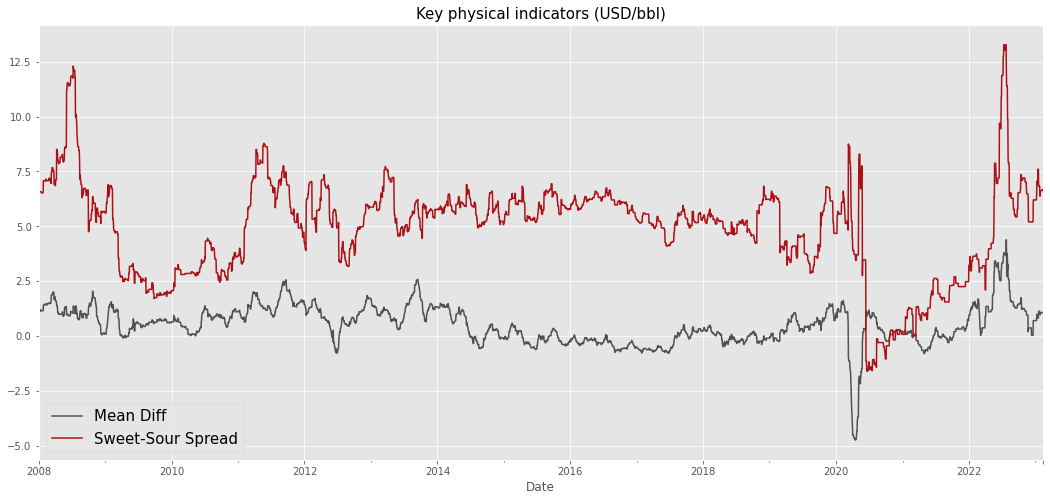

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Key physical indicators (USD/bbl)', fontsize = 15)
daily_df[['Mean Diff', 'Sweet-Sour Spread']].plot(ax=ax, color = [grey7, red7])
ax.legend(fontsize = 15);

## **PMIs**

In the search for variables shaping oil markets we could not ignore key leading economic indicators, such as Manufacturing or Non-Manufacturing PMIs (Purchasing Manager's Indexes).

In [ ]:
manuf_pmi_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Monthly',
                         index_col = 0,
                         usecols = "L:P",
                         parse_dates = True)
manuf_pmi_df.index.name = 'Date'
manuf_pmi_df.dropna(how='all', inplace=True)
manuf_pmi_df.isnull().sum()

EU PMI Manuf       119
US PMI Manuf         0
China PMI Manuf      0
India PMI Manuf    145
dtype: int64

The history is not as long as we would wish for in case of some countries (India, EU) which is why we will choose to work with:

1.   US => as sole representative of develeoped economies
2.   China => as sole representative of emerging economies
 

In [ ]:
manuf_pmi_df.drop(manuf_pmi_df.loc[:,['EU PMI Manuf','India PMI Manuf']], axis=1, inplace=True)
manuf_pmi_df.head(3)

,US PMI Manuf,China PMI Manuf
Date,,
2008-01-31,50.9,53.0
2008-02-29,48.8,53.4
2008-03-31,49.7,58.4


We shall also include nonmanufacturing PMIs for completness.

In [ ]:
non_manuf_pmi_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Monthly',
                         index_col = 0,
                         usecols = "R:V",
                         parse_dates = True)
non_manuf_pmi_df.index.name = 'Date'
non_manuf_pmi_df.dropna(how='all', inplace=True)
non_manuf_pmi_df.drop(non_manuf_pmi_df.loc[:,['EU PMI Non  Manuf','India PMI Non Manuf']], axis=1, inplace=True)
non_manuf_pmi_df.head(3)

,US PMI Non Manuf,China PMI Non Manuf
Date,,
2008-01-31,44.8,60.2
2008-02-29,49.9,59.3
2008-03-31,49.4,58.9


Once the data is read in and merged we are ready to visualize the indicators.

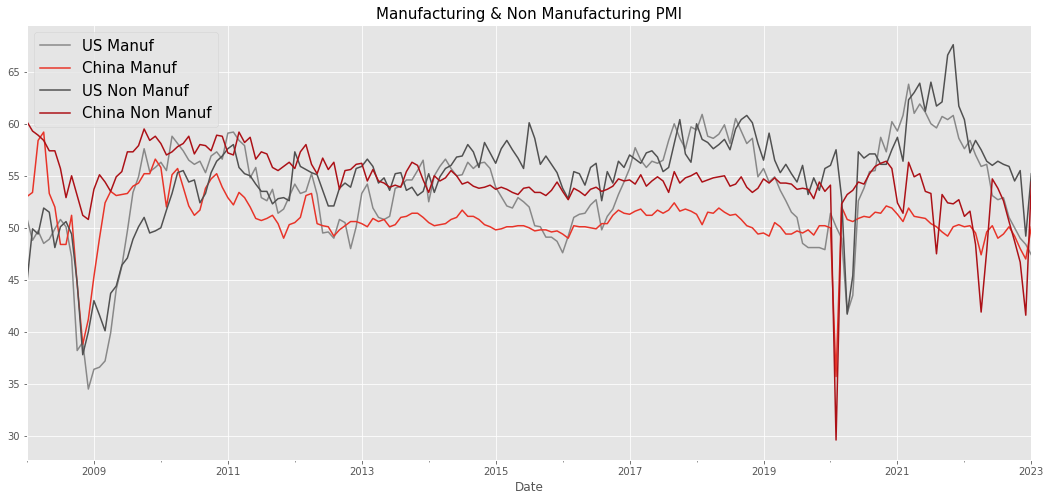

In [ ]:
pmi_df=pd.merge(left = manuf_pmi_df, right = non_manuf_pmi_df, on = 'Date')
cols_dict = {'US PMI Manuf':'US Manuf','China PMI Manuf':'China Manuf', 'US PMI Non Manuf':'US Non Manuf', 'China PMI Non Manuf':'China Non Manuf'}
pmi_df.rename(columns=cols_dict, inplace=True)
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Manufacturing & Non Manufacturing PMI', fontsize = 15)
pmi_df.plot(ax=ax, color = [grey3, red3, grey7, red7])
ax.legend(fontsize = 15);

Just like in previous cases, we will reduce dimensionality of the data by taking mean of the indicators.

In [ ]:
pmi_df['PMI'] = pmi_df.apply(lambda x : x.mean(), axis=1)
pmi_df.drop(pmi_df.loc[:,'US Manuf':'China Non Manuf'], axis=1, inplace=True)
pmi_df.index = pmi_df.index + pd.Timedelta(1, unit='d') + 0*BDay()

Which leaves us with the following...

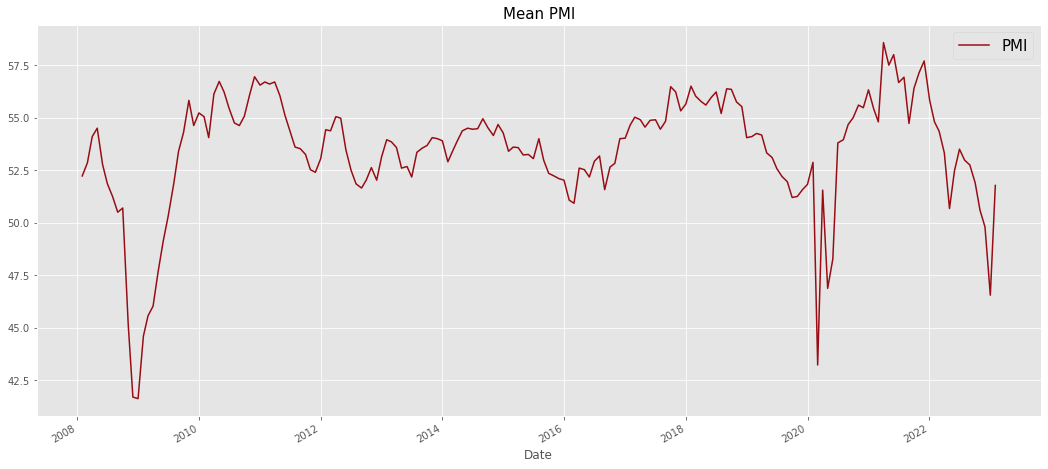

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Mean PMI', fontsize = 15)
pmi_df.plot(ax=ax, color = [red8])
ax.legend(fontsize = 15);

## **Central Banks**

Key central banks play a vital role in shaping commodities markets and oil market in particular. Examples of the influence are:
* amount of liquidity injected into the monetary system (extra money often ends up chasing risky assets, oil in particular)
* dynamics of key reference interest rates, either loosening or tightening monetary policy

Let's start from key central banks' assets...

In [ ]:
ecb_assets_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Monthly',
                         usecols = "X:Y",
                         index_col = 0,
                         names = ['Date', 'ECB Total Assets'], #skiprows = [0],
                         parse_dates = True)
fed_assets_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Monthly',
                         usecols = "AA:AB",
                         index_col = 0,
                         names = ['Date', 'FED Total Assets'], #skiprows = [0],
                         parse_dates = True)

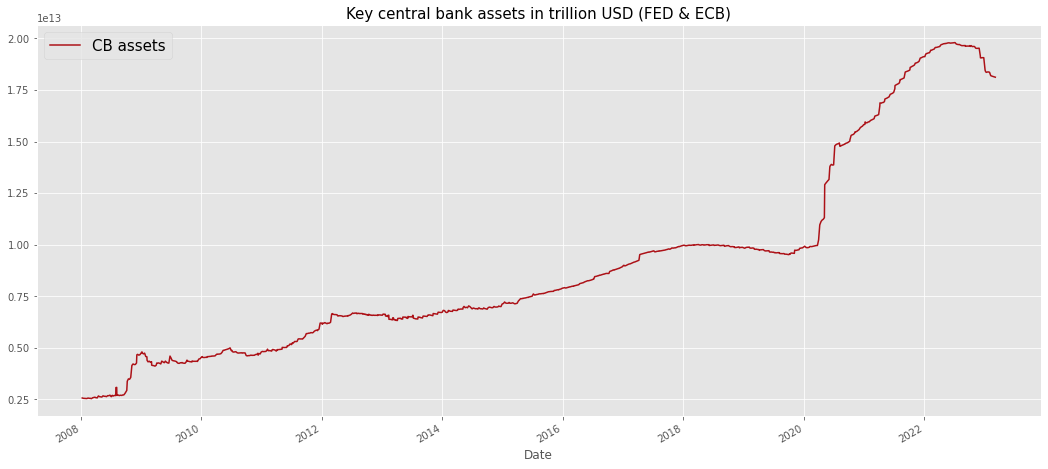

In [ ]:
assets_df = pd.merge(left = ecb_assets_df, right = fed_assets_df, how = 'outer', on = 'Date')
assets_df.dropna(how='all', inplace=True)
assets_df.sort_index(inplace = True, ascending = True)
assets_df.ffill(inplace=True)
assets_df.backfill(inplace=True)
assets_df['CB assets'] = assets_df.apply(lambda x : x['FED Total Assets'] + (x['ECB Total Assets']*1.23), axis=1)
assets_df.drop(assets_df.loc[:,'ECB Total Assets':'FED Total Assets'], axis=1, inplace=True)
assets_df.index = assets_df.index + pd.Timedelta(7, unit='d')
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Key central bank assets in trillion USD (FED & ECB)', fontsize = 15)
assets_df.plot(ax=ax, color = [red7])
ax.legend(fontsize = 15);

On the same note it is now time for key interest rates....

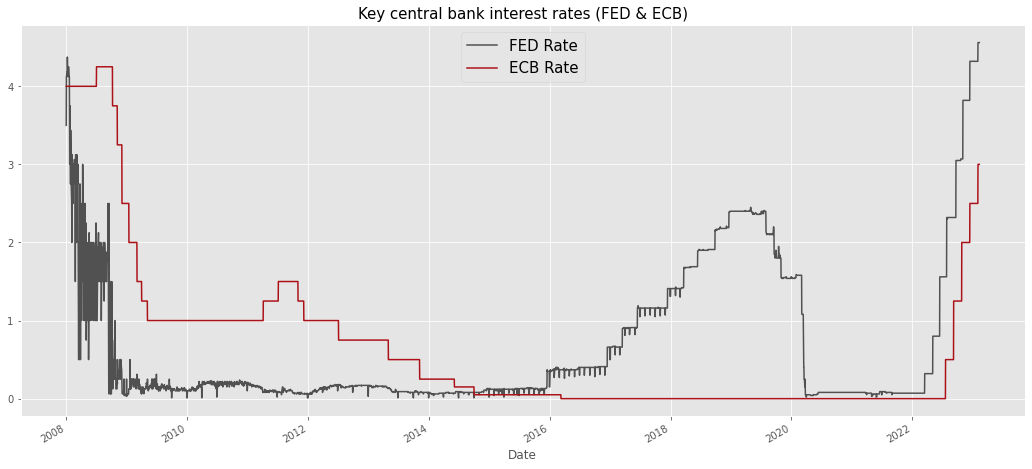

In [ ]:
ecb_rates_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Interest_Rates',
                         usecols = "A:B",
                         index_col = 0,
                         names = ['Date', 'ECB Rate'], #skiprows = [0],
                         parse_dates = True)
fed_rates_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Interest_Rates',
                         usecols = "D:E",
                         index_col = 0,
                         names = ['Date', 'FED Rate'], #skiprows = [0],
                         parse_dates = True)
ecb_rates_df.dropna(how='all', inplace=True)
fed_rates_df.dropna(how='all', inplace=True)
rates_df = pd.merge(left = fed_rates_df, right = ecb_rates_df, how = 'outer', on = 'Date')
rates_df.dropna(how='all', inplace=True)
rates_df.sort_index(inplace = True, ascending = True)
rates_df.ffill(inplace=True)
rates_df.backfill(inplace=True)
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Key central bank interest rates (FED & ECB)', fontsize = 15)
rates_df.plot(ax=ax, color = [grey7, red7])
ax.legend(fontsize = 15);

Let's reduce the input to one...

In [ ]:
rates_df['Mean CB Rate'] = rates_df.apply(lambda x : x.mean(), axis=1)
rates_df.drop(rates_df.loc[:,'FED Rate':'ECB Rate'], axis=1, inplace=True)
rates_df.index = rates_df.index + 0*BDay()

## **Speculative Money**

Beyond any doubt posiotioning of speculative money (aka managed money) has a meaningful influence on oil price formation.

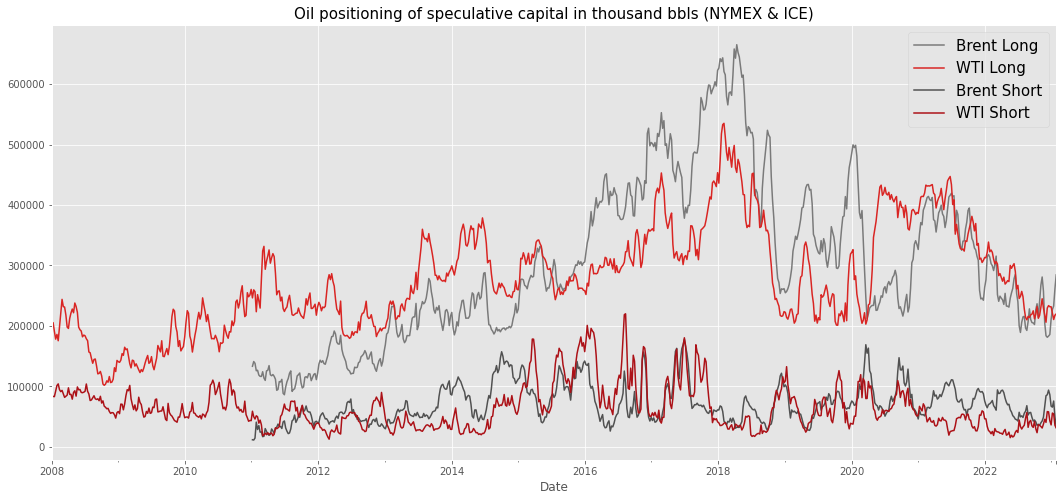

In [ ]:
weekly_spec_positions_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Weekly',
                         index_col = 0,
                         usecols = "A:E", #skiprows = [0],
                         parse_dates = True)
weekly_spec_positions_df.index.name = 'Date'
weekly_spec_positions_df.index = (weekly_spec_positions_df.index + np.timedelta64(1, 'D')+ 0*BDay()).normalize()
weekly_spec_positions_df.dropna(how='all', inplace=True)
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Oil positioning of speculative capital in thousand bbls (NYMEX & ICE)', fontsize = 15)
weekly_spec_positions_df.plot(ax=ax, color = [grey4, red4, grey7, red7])
ax.legend(fontsize = 15);

What is of true significance is a net position (Long vs Short) as visualized on the following chart....

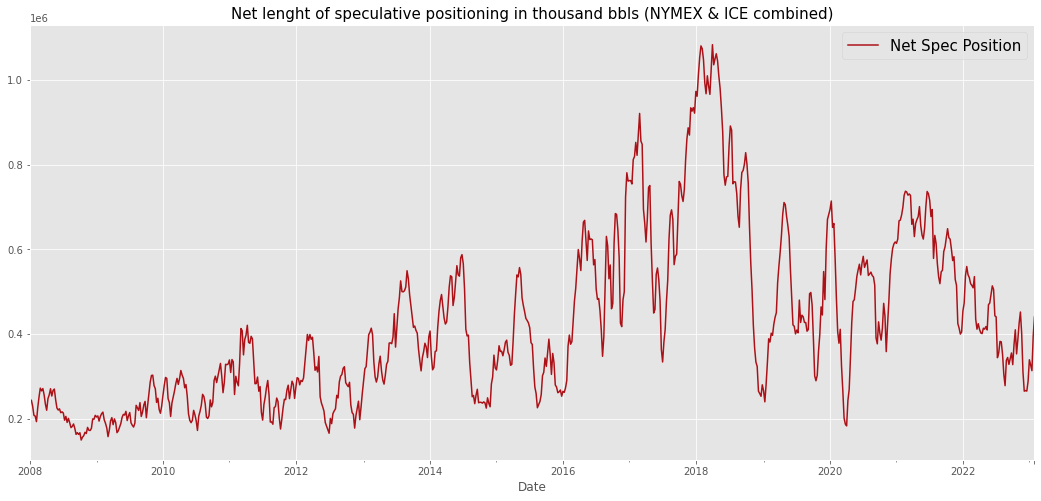

In [ ]:
weekly_spec_positions_df.ffill(inplace=True)
weekly_spec_positions_df.backfill(inplace=True)
weekly_spec_positions_df['Net Spec Position'] = weekly_spec_positions_df.apply(lambda x : (x['Brent Long'] + x['WTI Long']) - (x['Brent Short'] + x['WTI Short']), axis=1)
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Net lenght of speculative positioning in thousand bbls (NYMEX & ICE combined)', fontsize = 15)
weekly_spec_positions_df['Net Spec Position'].plot(ax=ax, color = [red7])
ax.legend(fontsize = 15);

## **Oil Inventory**

Last but not least our focus should be set on core oil markets fundamentals. Let's have a look at historical developments of:
* global oil stock movements
* outright volume of OECD oil stocks

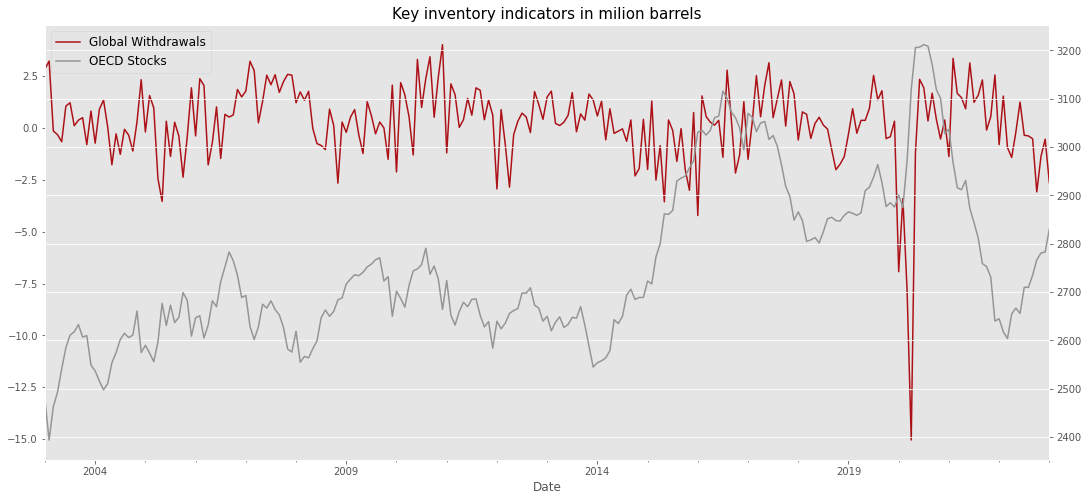

In [ ]:
monthly_inv_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Monthly',
                         usecols = "AD:AF",
                         names = ['Date', 'Global Net Withdrawals', 'OECD Inventory'],
                         index_col = 0,
                         parse_dates = True)
monthly_inv_df.dropna(how='all', inplace=True)
del_index = monthly_inv_df[monthly_inv_df.index > '2023-01-01'].index
monthly_inv_df.drop(del_index, inplace=True)
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Key inventory indicators in milion barrels', fontsize = 15)
monthly_inv_df['Global Net Withdrawals'].plot(ax=ax,color=red7, label = 'Global Withdrawals')
monthly_inv_df['OECD Inventory'].plot(ax=ax, color = grey2, secondary_y=True, label = 'OECD stocks')
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]],\
          ['Global Withdrawals','OECD Stocks'], fontsize=12);

Outright levels are important but way more significant is positioning of the OECD stock level versus 5 year average which is closly monitored by OPEC (or wider coalition OPEC PLUS) while fine tuning supply side of things...

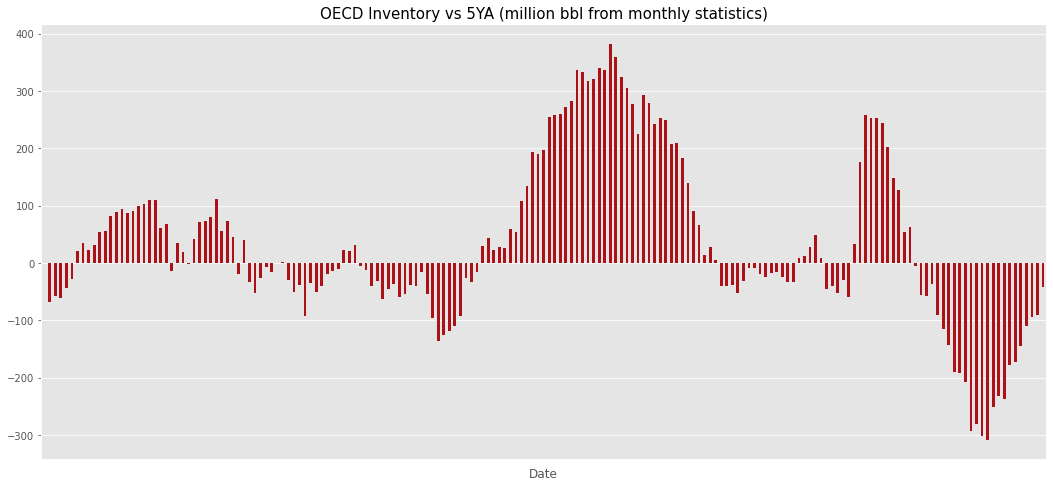

In [ ]:
monthly_inv_df['OECD Inventory vs 5YA'] = monthly_inv_df['OECD Inventory'] - monthly_inv_df['OECD Inventory'].rolling(60).mean()
del_index = monthly_inv_df[monthly_inv_df.index < '2008-01-01'].index
monthly_inv_df.drop(del_index, inplace=True)
monthly_inv_df.drop(monthly_inv_df.loc[:,'Global Net Withdrawals':'OECD Inventory'], axis=1, inplace=True)
monthly_inv_df.index = (monthly_inv_df.index + np.timedelta64(44, 'D')+ 0*BDay()).normalize()
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('OECD Inventory vs 5YA (million bbl from monthly statistics)', fontsize = 15)
monthly_inv_df['OECD Inventory vs 5YA'].plot.bar(ax=ax,color=red7)
ax.set_xticks([]);

The concerning element is a significant delay in publishing of the statistics on the monthly basis. In order to fix that we may be tempted to use high-frequency inventory statistics from:

1.   USA
2.   ARA
3.   Japan
4.   Singapore
5.   Fujairah




In [ ]:
weekly_us_stocks_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Weekly',
                         usecols = "J:Q",
                         index_col = 0,
                         names = ['Date', 'USA Crude', 'USA Mogas', 'USA Distilates', 'USA Fuel Oil',\
                                  'USA Reformates', 'USA Jet', 'USA Total'],
                         parse_dates = True)
weekly_ara_stocks_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Weekly',
                         usecols = "T:Y",
                         index_col = 0,
                         names = ['Date', 'ARA Gasoline', 'ARA Naphta', 'ARA Gas Oil',\
                                  'ARA Fuel Oil', 'ARA Jet'],
                         parse_dates = True)
weekly_japan_stocks_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Weekly',
                         usecols = "AC:AK",
                         index_col = 0,
                         names = ['Date', 'JAPAN Crude', 'JAPAN Gasoil', 'JAPAN HS Diesel', 'JAPAN Gasoline',\
                                  'JAPAN Naphta', 'JAPAN Kerosene', 'JAPAN Jet', 'JAPAN Fuel Oil '],
                         parse_dates = True)
weekly_singapore_stocks_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Weekly',
                         usecols = "AN:AQ",
                         index_col = 0,
                         names = ['Date', 'Singapore Light Disct', 'Singapore Middle Dist','Singapore Heavy Dist'],
                         parse_dates = True)
weekly_fujairah_stocks_df = pd.read_excel('ICE_Brent_Data_Feed.xlsx',
                         sheet_name='Weekly',
                         usecols = "AU:AX",
                         index_col = 0,
                         names = ['Date', 'Fujairah Light Disct', 'Fujairah Middle Dist', 'Fujairah Heavy Dist'],
                         parse_dates = True)
weekly_us_stocks_df.dropna(how='all', inplace=True)
weekly_ara_stocks_df.dropna(how='all', inplace=True)
weekly_japan_stocks_df.dropna(how='all', inplace=True)
weekly_singapore_stocks_df.dropna(how='all', inplace=True)
weekly_fujairah_stocks_df.dropna(how='all', inplace=True)

In [ ]:
weekly_us_stocks_df = weekly_us_stocks_df.applymap(lambda x : x * 1000)
weekly_ara_stocks_df['ARA Gasoline'] = weekly_ara_stocks_df['ARA Gasoline'].apply(lambda x : x*8.5)
weekly_ara_stocks_df['ARA Naphta'] = weekly_ara_stocks_df['ARA Naphta'].apply(lambda x : x*8.8)
weekly_ara_stocks_df['ARA Gas Oil'] = weekly_ara_stocks_df['ARA Gas Oil'].apply(lambda x : x*7.5)
weekly_ara_stocks_df['ARA Fuel Oil'] = weekly_ara_stocks_df['ARA Fuel Oil'].apply(lambda x : x*6.5)
weekly_ara_stocks_df['ARA Jet'] = weekly_ara_stocks_df['ARA Jet'].apply(lambda x : x*7.5)
weekly_ara_stocks_df['ARA Total'] = weekly_ara_stocks_df.apply(lambda x : x.sum(), axis=1)
weekly_japan_stocks_df = weekly_japan_stocks_df.applymap(lambda x : x / 1000)
weekly_japan_stocks_df['JAPAN Total'] = weekly_japan_stocks_df.apply(lambda x : x.sum(), axis=1)
weekly_singapore_stocks_df = weekly_singapore_stocks_df.applymap(lambda x : x * 1000)
weekly_singapore_stocks_df['SINGAPORE Total'] = weekly_singapore_stocks_df.apply(lambda x : x.sum(), axis=1)
weekly_fujairah_stocks_df['FUJAIRAH Total'] = weekly_fujairah_stocks_df.apply(lambda x : x.sum(), axis=1)

In [ ]:
weekly_inv_df = pd.DataFrame()
weekly_inv_df.index.name = 'Date'
df_list = [weekly_us_stocks_df, weekly_ara_stocks_df, weekly_japan_stocks_df, weekly_singapore_stocks_df, weekly_fujairah_stocks_df]
for df in df_list:
  weekly_inv_df = pd.merge(left = weekly_inv_df, right = df.iloc[:,-1:], how = 'outer', on = 'Date')
weekly_inv_df.sort_index(inplace = True, ascending = True)
weekly_inv_df.index = (weekly_inv_df.index + np.timedelta64(3, 'D')+ 0*BDay()).normalize()  
weekly_inv_df.ffill(inplace=True)
weekly_inv_df.backfill(inplace=True)
weekly_inv_df['HFS Total'] = weekly_inv_df.apply(lambda x : x.sum(), axis=1)
weekly_inv_df['HFS vs 5YA'] = weekly_inv_df['HFS Total'] - weekly_inv_df['HFS Total'].rolling(60).mean()

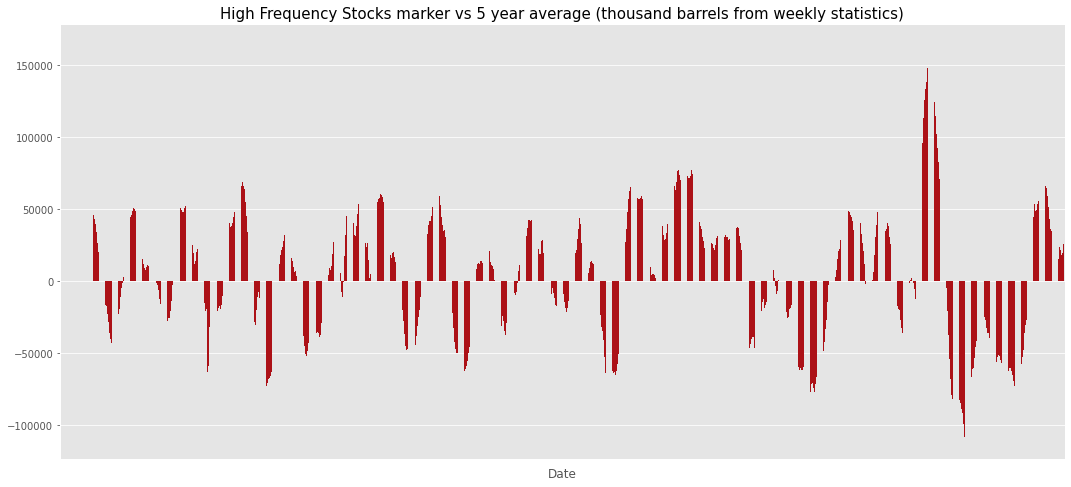

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('High Frequency Stocks marker vs 5 year average (thousand barrels from weekly statistics)', fontsize = 15)
weekly_inv_df['HFS vs 5YA'].rolling(5).mean().plot.bar(ax=ax,color=red7)
ax.set_xticks([]);

# **Data Fine-Tuning** 

Time to merge multiple data frames into one data structure, check interdependecies, normalize and prepare for supervised learning...

## **Merging Data**

We have been working with quite a few data frames here. Let's join them.

In [ ]:
df_list = [pmi_df[['PMI']], assets_df[['CB assets']], rates_df[['Mean CB Rate']], weekly_spec_positions_df[['Net Spec Position']],\
           monthly_inv_df[['OECD Inventory vs 5YA']], weekly_inv_df[['HFS vs 5YA']] ] #
for df in df_list:
  daily_df = pd.merge(left = daily_df, right = df, how = 'left', on = 'Date')
daily_df.sort_index(inplace = True, ascending = True)
daily_df.ffill(inplace=True)
daily_df.backfill(inplace=True)

In [ ]:
daily_df.head()

,Brent M1,US Dollar Index,MSCI world equity,1M_Structure,1Y_Structure,Gasoi_Crack,3-2-1 Margin,EM Index,10Y vs 2Y Delta,Mean Diff,Sweet-Sour Spread,PMI,CB assets,Mean CB Rate,Net Spec Position,OECD Inventory vs 5YA,HFS vs 5YA
Date,,,,,,,,,,,,,,,,,
2008-01-01,97.84,76.01,403.26,0.25,4.58,16.925101,24.7080,63.507702,1.0230,0.875,6.200,52.225,2.554838e+12,3.75000,243029.0,-0.483333,-49494.591040
2008-01-02,97.84,76.01,400.47,0.25,4.58,16.925101,24.7080,63.507702,1.0230,0.875,6.200,52.225,2.554838e+12,3.75000,243029.0,-0.483333,-49494.591040
2008-01-03,97.60,75.92,399.81,0.22,4.02,17.903356,24.9234,63.351048,1.0789,0.875,6.200,52.225,2.554838e+12,4.06250,243029.0,-0.483333,-49494.591040
2008-01-04,96.79,75.82,392.26,0.28,3.56,16.834161,26.2638,63.504536,1.1347,1.125,6.575,52.225,2.554838e+12,4.06250,243029.0,-0.483333,-49494.591040
2008-01-07,94.39,76.20,390.23,0.24,3.10,15.207315,24.9630,63.523577,1.0795,1.125,6.575,52.225,2.554838e+12,4.09375,243029.0,-0.483333,-49713.776873


## **Factor importance**

We have extracted features found relevant based on our domain knowledge. Let's see their respective importance...

In [ ]:
daily_df.corr()['Brent M1'][1:].sort_values()

OECD Inventory vs 5YA   -0.658014
US Dollar Index         -0.588705
EM Index                -0.413542
Net Spec Position       -0.264938
HFS vs 5YA              -0.205490
CB assets               -0.187594
MSCI world equity       -0.169785
PMI                      0.215770
Mean CB Rate             0.257387
10Y vs 2Y Delta          0.337871
Sweet-Sour Spread        0.358686
Gasoi_Crack              0.450090
1M_Structure             0.496216
3-2-1 Margin             0.500819
1Y_Structure             0.605516
Mean Diff                0.635243
Name: Brent M1, dtype: float64

As always... it is way more convenient to visualize such things so let's get to it.

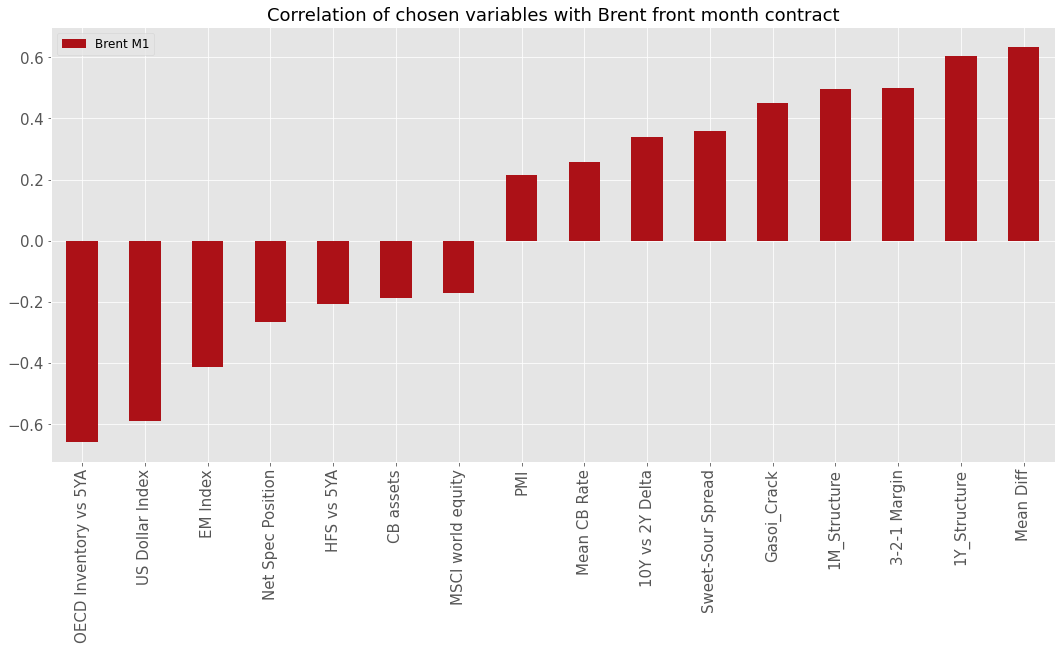

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.set_title('Correlation of chosen variables with Brent front month contract', fontsize = 18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
daily_df.corr()['Brent M1'][1:].sort_values().plot.bar(ax=ax,color=red7)
ax.legend(fontsize=12);

## **Train / Test split**

If we hadn't dealt with time series, we would certainly use famous train_test_split from sklearn.model_selection but modelling of time series requires a dedicated approach. In simple terms it comes down to curving a train set up to a certain cutt-off point while the remaining data points constitute a test set. We will also shorten the period to save some time while waiting for computations to run.

In [ ]:
start_date = dt.date(2013, 1, 1) 
end_date = dt.date(2023, 1, 1)
daily_copy = daily_df.loc[start_date:end_date].copy()

for i in range(5):
  daily_copy[f'Brent {-i-1}'] = daily_copy['Brent M1'].shift(periods=i+1)

X = daily_copy.dropna().drop('Brent M1', axis=1).astype(np.float32)
y = daily_copy.dropna()['Brent M1'].astype(np.float32)

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2083, 2083, 521, 521)

## **Data Normalization**

We have enormous differences in ranges of values for different time series. As per standard practice in machine learning pipeline we will adjust numeric columns in the dataset to a common scale. 

In [ ]:
col_trans = make_column_transformer((MinMaxScaler(),['US Dollar Index', 'MSCI world equity', '1M_Structure', '1Y_Structure','Gasoi_Crack', '3-2-1 Margin', 'EM Index',
                                                     '10Y vs 2Y Delta','Mean Diff', 'Sweet-Sour Spread', 'PMI', 'CB assets', 'Mean CB Rate', 'Net Spec Position',
                                                     'OECD Inventory vs 5YA', 'HFS vs 5YA', 'Brent -1','Brent -2', 'Brent -3', 'Brent -4', 'Brent -5']))
col_trans.fit(X_train)
X_train_norm = col_trans.transform(X_train)
X_test_norm = col_trans.transform(X_test)

# **Models tried**

Now would be a good moment to eventually try modeling Brent prices using different deep learning approaches. As a baseline we will use our faithful naive model.



| Number | Model Type | Layers | Units | |
| ----- | ----- | ----- | ----- | - |
| 1 | Naive |   NA |   NA |
| 2 | MLP | 1 / 3  |   128 / 256 |
| 3 | LSTM | 1 / 3  |   128 / 256 |
| 4 | CNN | 1 / 3  |   128 / 256 | 

## **Naive** 

Let's start from setting a benchmark for the assessment of effectiveness of all other models tried. The obvious choice is usually a naive model which assumes persistence of past data into the future. We will test lags 1 through 4 by default.

In [ ]:
def naive_model_configs(lags = 4):
  n_options = [i for i in range(1, lags +1)]
  return n_options
  
def naive_forecast(data, configuration):
  return data[-configuration]

def avg_naive_error(train_data, test_data, configuration, iterator):
  # start_time = timer()
  naive_archive = train_data.copy()
  naive_predictions = list()
  for i in range(len(test_data)):
    y_hat = naive_forecast(naive_archive, configuration)
    naive_predictions.append(y_hat)
    naive_archive = pd.concat([naive_archive, test_data[i:i+1]])
  try:
    naive_error = assess_predictions(test_data, naive_predictions).round(3)
  except:
    naive_error = None
  # end_time = timer() #dt.datetime.now()
  # print(f"Model: {iterator+1} \t Error: {naive_error:.3f} \t \t Configuration: {configuration} \t \t Time: {round((end_time - start_time)/60,2)}")
  return (np.round(naive_error,3), configuration)

def naive_grid_search(train_set, test_set, naive_conf_options):
  # start_point = timer()
  naive_results = [avg_naive_error(train_data = train_set, test_data = test_set, configuration = config, iterator=index) for index, config in enumerate(naive_conf_options)]
  naive_results = [r for r in naive_results if r[0] != None]
  naive_results.sort(key=lambda tup: tup[0])
  # end_point = timer()
  #print(f"\n Total of {len(naive_conf_options)} models calculated in {round((end_point - start_point)/60,2)} minutes.")
  naive_df = pd.DataFrame(data = naive_results,
                          columns =['error', 'config'])
  return naive_df

In [ ]:
naive_confs = naive_model_configs(lags = 4)
naive_gs = naive_grid_search(train_set = y_train,
                             test_set = y_test,
                             naive_conf_options = naive_confs)
naive_gs

,error,config
0,2.576,1
1,3.703,2
2,4.405,3
3,4.843,4


Without surprises, best results yielded a naive model with a lag of 1 which alligns well with our intuition.

## **MLP**

MLP stands for Multi Layer Perceptron aka a dense model. True, it is not natively skilled to work with sequential data but we will still give it a go.

In [ ]:
def mlp_model_configs():
  n_layers_options = [3, 5]
  n_units_options = [128, 256]
  n_steps_in_options = [5]
  n_batch_size_options = [1]
  n_dropout_options = [0.10]
  cfg_list = list()
  for i in n_layers_options:
    for j in n_units_options:
      for k in n_steps_in_options:
        for l in n_batch_size_options:
          for m in n_dropout_options:
            configuration = [i, j, k, l, m]
            cfg_list.append(configuration)
  return cfg_list

def get_mlp(configuration, train_data, test_data):
  n_epochs, n_outputs = 80, 1
  n_layers, n_units, n_inputs, n_batch_size, n_dropout_ratio = configuration
  checkpoint_path = "mlp_checkpoints_weights/checkpoint.ckpt"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         save_freq = "epoch",
                                                         verbose=0)  
  X_train, y_train = train_data #vectorized_split_sequence(sequence = train_data, steps_in = n_inputs, steps_out = n_outputs)
  X_test, y_test = test_data #vectorized_split_sequence(sequence = test_data, steps_in = n_inputs, steps_out = n_outputs)
  X_train_tf = tf.cast(X_train, dtype = tf.float32)
  y_train_tf = tf.cast(y_train, dtype = tf.float32)
  X_val_tf = tf.cast(X_test, dtype = tf.float32)
  y_val_tf = tf.cast(y_test, dtype = tf.float32)
  model = tf.keras.Sequential(name = f"mlp_{n_layers}_{n_units}_{n_inputs}_{n_batch_size}_{int(n_dropout_ratio*100)}")
  if n_layers==1:
    model.add(tf.keras.layers.Dense(n_units, activation='relu')) #, input_dim = n_inputs
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  else:
    model.add(tf.keras.layers.Dense(n_units, activation='relu')) #, input_dim = n_inputs
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    for i in range(1, n_layers):
      model.add(tf.keras.layers.Dense(n_units, activation='relu')) #, input_dim = inputs
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  model.add(tf.keras.layers.Dense(n_outputs))
  model.compile(loss = 'mse',
                optimizer='adam')
 
  model.fit(x = X_train_tf,
            y = y_train_tf,
            batch_size = n_batch_size, 
            epochs = n_epochs,
            verbose=0,
            validation_data=(X_val_tf, y_val_tf),
            callbacks = [checkpoint_callback])
  model.load_weights(filepath = checkpoint_path)

  model_path = f"saved_models/{model.name}" 
  model.save(model_path) 

  predictions = model.predict(X_val_tf) #tf.constant
  error = assess_predictions(y_val_tf, predictions).round(3)

  return error, configuration, model.name, model_path

def mlp_grid_search(configuration_list, train_set, test_set):
  mlp_results = list()
  for conf in configuration_list:
    result = get_mlp(configuration = conf,
                     train_data = train_set,
                     test_data = test_set)
    mlp_results.append(result)
    mlp_results.sort(key=lambda tup:tup[0])
    mlp_df = pd.DataFrame(data = mlp_results,
                          columns =['error', 'config', 'model_name', 'model_path'])
  return mlp_df

In [ ]:
mlp_configs = mlp_model_configs()
mlp_gs = mlp_grid_search(configuration_list = mlp_configs,
                         train_set = (X_train_norm, y_train),
                         test_set = (X_test_norm, y_test))
mlp_gs

5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


,error,config,model_name,model_path
0,2.508,"[3, 256, 5, 1, 0.1]",mlp_3_256_5_1_10,saved_models/mlp_3_256_5_1_10
1,2.831,"[3, 128, 5, 1, 0.1]",mlp_3_128_5_1_10,saved_models/mlp_3_128_5_1_10
2,3.083,"[5, 256, 5, 1, 0.1]",mlp_5_256_5_1_10,saved_models/mlp_5_256_5_1_10
3,4.093,"[5, 128, 5, 1, 0.1]",mlp_5_128_5_1_10,saved_models/mlp_5_128_5_1_10


It does outperform naive model. Now time for some recurrent neural net...

## **LSTM**

LSTM stands for Long-Short Term Memory cells that were specifically designed to work with  sequences. Let's find out if they indeed show higher skills than a regular dense model... 

In [ ]:
def lstm_model_configs():
  n_layers_options = [1,3]
  n_units_options = [128, 256]
  n_steps_in_options = [5]
  n_batch_size_options = [1]
  n_dropout_options = [0.10]
  cfg_list = list()
  for i in n_layers_options:
    for j in n_units_options:
      for k in n_steps_in_options:
        for l in n_batch_size_options:
          for m in n_dropout_options:
            configuration = [i, j, k, l, m]
            cfg_list.append(configuration)
  return cfg_list

def get_lstm(configuration, train_data, test_data):
  n_epochs, n_outputs = 80, 1
  n_layers, n_units, n_inputs, n_batch_size, n_dropout_ratio = configuration
  checkpoint_path = "lstm_checkpoints_weights/checkpoint.ckpt"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         save_freq = "epoch",
                                                         verbose=0)  
  X_train, y_train = train_data #vectorized_split_sequence(sequence = train_data, steps_in = n_inputs, steps_out = n_outputs)
  X_test, y_test = test_data #vectorized_split_sequence(sequence = test_data, steps_in = n_inputs, steps_out = n_outputs)
  X_train_tf = tf.expand_dims(X_train, axis = 2)
  y_train_tf = tf.cast(y_train, dtype = tf.float32)
  X_val_tf = tf.expand_dims(X_test, axis = 2)
  y_val_tf = tf.cast(y_test, dtype = tf.float32)
  model = tf.keras.Sequential(name = f"lstm_{n_layers}_{n_units}_{n_inputs}_{n_batch_size}_{int(n_dropout_ratio*100)}")
  if n_layers==1:
    model.add(tf.keras.layers.LSTM(n_units, activation='relu', input_shape = (21,1))) #n_inputs
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  elif n_layers == 2:
      model.add(tf.keras.layers.LSTM(n_units, activation='relu', return_sequences = True, input_shape = (21, 1))) #n_inputs
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
      model.add(tf.keras.layers.LSTM(n_units, activation='relu'))
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  else:
    model.add(tf.keras.layers.LSTM(n_units, activation='relu', return_sequences = True, input_shape = (21, 1))) #n_inputs
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    for i in range(2, n_layers):
      model.add(tf.keras.layers.LSTM(n_units, activation='relu', return_sequences = True))
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.LSTM(n_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
  model.add(tf.keras.layers.Dense(n_outputs))
  model.compile(loss = 'mse',
                optimizer='adam')
 
  model.fit(x = X_train_tf,
            y = y_train_tf,
            batch_size = n_batch_size, 
            epochs = n_epochs,
            verbose=0,
            validation_data=(X_val_tf, y_val_tf),
            callbacks = [checkpoint_callback])
  model.load_weights(filepath = checkpoint_path)

  model_path = f"saved_models/{model.name}" 
  model.save(model_path) #/content/drive/MyDrive/models
  
  predictions = model.predict(X_val_tf) #tf.constant
  error = assess_predictions(y_val_tf, predictions).round(3)

  return error, configuration, model.name, model_path

def lstm_grid_search(configuration_list, train_set, test_set):
  lstm_results = list()
  for conf in configuration_list:
    result = get_lstm(configuration = conf,
                     train_data = train_set,
                     test_data = test_set)
    lstm_results.append(result)
    lstm_results.sort(key=lambda tup:tup[0])
    lstm_df = pd.DataFrame(data = lstm_results,
                          columns =['error', 'config', 'model_name', 'model_path'])
  return lstm_df

In [ ]:
lstm_configs = lstm_model_configs()
lstm_gs = lstm_grid_search(configuration_list = lstm_configs,
                         train_set = (X_train_norm, y_train),
                         test_set = (X_test_norm, y_test))

In [ ]:
lstm_gs

,error,config,model_name,model_path
0,4.111,"[1, 128, 5, 1, 0.1]",lstm_1_128_5_1_10,saved_models/lstm_1_128_5_1_10
1,4.715,"[1, 256, 5, 1, 0.1]",lstm_1_256_5_1_10,saved_models/lstm_1_256_5_1_10
2,6.190,"[3, 256, 5, 1, 0.1]",lstm_3_256_5_1_10,saved_models/lstm_3_256_5_1_10
4,9.448,"[3, 128, 5, 1, 0.1]",lstm_3_128_5_1_10,saved_models/lstm_3_128_5_1_10


## **CNN**

CNN stands for Convolutional Neural Network. This very class of artificial neural nets was specifically designed to work with vision (images & video) but it may be used for time series analyses too.

In [ ]:
def cnn_model_configs():
  n_layers_options = [1,3]
  n_units_options = [128, 256]
  n_steps_in_options = [5]
  n_batch_size_options = [1]
  n_dropout_options = [0.10]
  cfg_list = list()
  for i in n_layers_options:
    for j in n_units_options:
      for k in n_steps_in_options:
        for l in n_batch_size_options:
          for m in n_dropout_options:
            configuration = [i, j, k, l, m]
            cfg_list.append(configuration)
  return cfg_list

def get_cnn(configuration, train_data, test_data):
  n_epochs, n_outputs = 80, 1
  n_layers, n_units, n_inputs, n_batch_size, n_dropout_ratio = configuration
  checkpoint_path = "cnn_checkpoints_weights/checkpoint.ckpt"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         save_freq = "epoch",
                                                         verbose=0)  
  X_train, y_train = train_data #vectorized_split_sequence(sequence = train_data, steps_in = n_inputs, steps_out = n_outputs)
  X_test, y_test = test_data #vectorized_split_sequence(sequence = test_data, steps_in = n_inputs, steps_out = n_outputs)
  X_train_tf = tf.cast(X_train, dtype = tf.float32)
  y_train_tf = tf.cast(y_train, dtype = tf.float32)
  X_test_tf = tf.cast(X_test, dtype = tf.float32)
  y_test_tf = tf.cast(y_test, dtype = tf.float32)
  model = tf.keras.Sequential(name = f"cnn_{n_layers}_{n_units}_{n_inputs}_{n_batch_size}_{int(n_dropout_ratio*100)}")
  model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))
  if n_layers==1:
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu', input_shape = (21, 1))) #n_inputs
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Flatten())
    
  elif n_layers == 2:
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu', input_shape = (21, 1))) #n_inputs
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu'))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Flatten())

  else:
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu', input_shape = (21, 1))) #n_inputs
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    for i in range(2, n_layers):
      model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu'))
      model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.Conv1D(filters = n_units, kernel_size = 3, padding = "causal", activation='relu'))
    model.add(tf.keras.layers.Dropout(n_dropout_ratio))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(n_outputs))

  model.compile(loss = 'mse',
                optimizer='adam')
 
  model.fit(x = X_train_tf,
            y = y_train_tf,
            batch_size = n_batch_size, 
            epochs = n_epochs,
            verbose=0, #0
            validation_data=(X_test_tf, y_test_tf),
            callbacks = [checkpoint_callback])
  model.load_weights(filepath = checkpoint_path)

  model_path = f"saved_models/{model.name}" 
  model.save(model_path)
  predictions = tf.squeeze(model.predict(X_test), axis=-1)
  error = assess_predictions(y_test_tf, predictions).round(3)
  
  return error, configuration, model.name, model_path

def cnn_grid_search(configuration_list, train_set, test_set):
  cnn_results = list()
  for conf in configuration_list:
    result = get_cnn(configuration = conf,
                     train_data = train_set,
                     test_data = test_set)
    cnn_results.append(result)
    cnn_results.sort(key=lambda tup:tup[0])
    cnn_df = pd.DataFrame(data = cnn_results,
                          columns =['error', 'config', 'model_name', 'model_path'])
  return cnn_df

In [ ]:
cnn_configs = cnn_model_configs()
cnn_gs = cnn_grid_search(configuration_list = cnn_configs,
                         train_set = (X_train_norm, y_train),
                         test_set = (X_test_norm, y_test))
cnn_gs

5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 2ms/step


5/5 [==============================] - 0s 8ms/step


5/5 [==============================] - 0s 10ms/step


,error,config,model_name,model_path
0,4.757,"[1, 256, 5, 1, 0.1]",cnn_1_256_5_1_10,saved_models/cnn_1_256_5_1_10
1,5.602,"[1, 128, 5, 1, 0.1]",cnn_1_128_5_1_10,saved_models/cnn_1_128_5_1_10
2,6.069,"[3, 128, 5, 1, 0.1]",cnn_3_128_5_1_10,saved_models/cnn_3_128_5_1_10
3,6.466,"[3, 256, 5, 1, 0.1]",cnn_3_256_5_1_10,saved_models/cnn_3_256_5_1_10


# **Executive Summary**

Time to collect results of the best 4 models of each class in a summary data frame.

In [10]:
results_df = pd.DataFrame({'naive': naive_gs.error,
                           'mlp': mlp_gs.error,
                           'lstm':lstm_gs.error,
                           'cnn': cnn_gs.error})
results_df.index = pd.RangeIndex(start=1, stop=5, step=1)
results_df.index = results_df.index.set_names(['rank'])
results_df

,naive,mlp,lstm,cnn
rank,,,,
1,2.576,2.508,4.111,4.757
2,3.703,2.831,4.715,5.602
3,4.405,3.083,6.190,6.069
4,4.843,4.093,9.448,6.466


It would not be a bad idea to visualize the results.

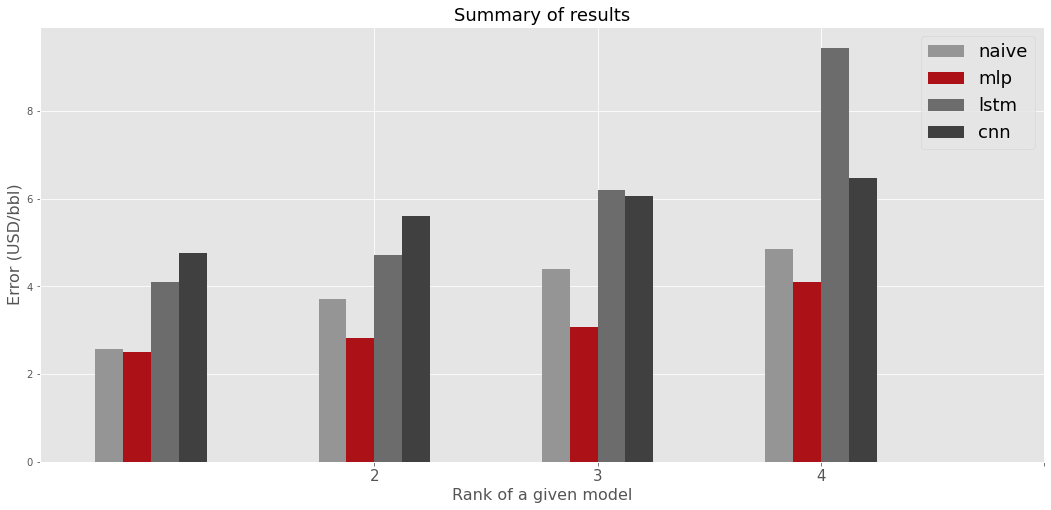

In [26]:
fig, ax = plt.subplots(figsize=(18,8))
results_df.plot.bar(ax = ax, color=[grey2, red7, grey5, grey8])
ax.set_title('Summary of results', fontsize = 18)
ax.set_xlabel("Rank of a given model", fontsize = 16)
ax.set_xticks(results_df.index, horizontalalignment="center")
ax.xaxis.set_tick_params(labelsize=15, rotation=0)
ax.set_ylabel("Error (USD/bbl)", fontsize = 16)
ax.legend(fontsize=18);

**Key takeaways:**



Dense model did managed to outperform underlying benchmark of naive model but let's be frank - it did not delighted us with results. Taking into account the complexity of the subject matter we should not be overly surprised though.

We could still try many different ways to improve on the results:

1.   add more layers to make deep learning deep (it's kind of shallow now)
2.   test different number of units / cells in a layer
3.   use more data (10, 15, 20 years)
4.   change granularity (from days into hours or minutes)
5.   adjust learning rate (or use learning rate scheduler)
6.   experiment with different activation functions
7.   check on initialization methods

Yet at he end of the day macine learning is mostly about experimentation.

Moreover, quite logical next steps would be:

*   leveraging NLP in order to include sentiment analysis into the experiments
*   examination of some algorthytmic strategies in search of added-value

